# Hypothese 4

**Hypothese:** Vormittags und Nachmittags sind die besten Zeiten zum Taxifahren.
**Operationalisierung:** "Beste Zeit" ist definiert durch:
1.  Höchste Durchschnittsgeschwindigkeit ($Speed$)
2.  Niedrigster Durchschnittspreis ($Price$)

## Statistische Methodik
Da wir die Tageszeit in mehrere Kategorien einteilen (z.B. Morgens, Vormittags, Nachmittags, Abends, Nachts), vergleichen wir **mehr als zwei Gruppen**. Hier ist ein **t-Test nicht zulässig** (Fehlerinflation durch multiple Vergleiche).

Stattdessen nutzen wir:
* **ANOVA (Analysis of Variance):** Wenn die Daten annähernd normalverteilt sind.
* **Kruskal-Wallis Test:** Als robuste Alternative, falls die Daten (wie bei Taxi-Preisen üblich) schief sind oder Ausreisser haben.
* **Post-hoc Tests (Tukey):** Um nach einem signifikanten Gesamtergebnis zu prüfen, *welche* Zeitfenster sich genau unterscheiden[cite: 948, 968].

**Nullhypothese ($H_0$):** Es gibt keinen Unterschied in Geschwindigkeit/Preis zwischen den Tageszeiten.

**Alternativhypothese ($H_1$):** Mindestens eine Tageszeit unterscheidet sich signifikant.

In [9]:
import sys
from pathlib import Path

# Pfad zum Root-Verzeichnis setzen (eine Ebene über notebooks/)
ROOT = Path.cwd().parent
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

# Standard Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

try:
    from src.utils_stats import iqr, trimmed_mean, tukey_fences, tukey_outliers, modified_z_score, ecdf, z_score, create_na_table
    from src.utils_plots import hist_kde, box_violin, plot_ecdf, hist_with_fences, plot_qq
    print("Custom 'src' Module erfolgreich geladen.")
except ImportError:
    print("Hinweis: Custom 'src' Module nicht gefunden. Nutze Standard-Bibliotheken.")

# Grafik-Style
sns.set_theme(style="whitegrid")

Custom 'src' Module erfolgreich geladen.


In [16]:
PATH = "../data/Taxi_final_1M_clean.csv"
df = pd.read_csv(PATH)

def get_time_of_day(hour):
    if 7 <= hour < 9:
        return 'Morgens (Rush)'
    elif 9 <= hour < 12:
        return 'Vormittag'
    elif 12 <= hour < 14:
        return 'Mittag'
    elif 14 <= hour < 17:
        return 'Nachmittag'
    elif 17 <= hour < 20:
        return 'Abend (Rush)'
    else:
        return 'Nacht'

df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['hour'] = df['tpep_pickup_datetime'].dt.hour

df['time_category'] = df['hour'].apply(get_time_of_day)

order = ['Morgens (Rush)', 'Vormittag', 'Mittag', 'Nachmittag', 'Abend (Rush)', 'Nacht']

print(df.groupby('time_category')[['average_speed', 'total_amount']].mean())

                average_speed  total_amount
time_category                              
Abend (Rush)        16.560834     28.954660
Mittag              16.138920     28.276320
Morgens (Rush)      19.515099     27.137989
Nachmittag          15.632051     30.590688
Nacht               22.386454     29.077713
Vormittag           17.010409     27.252427


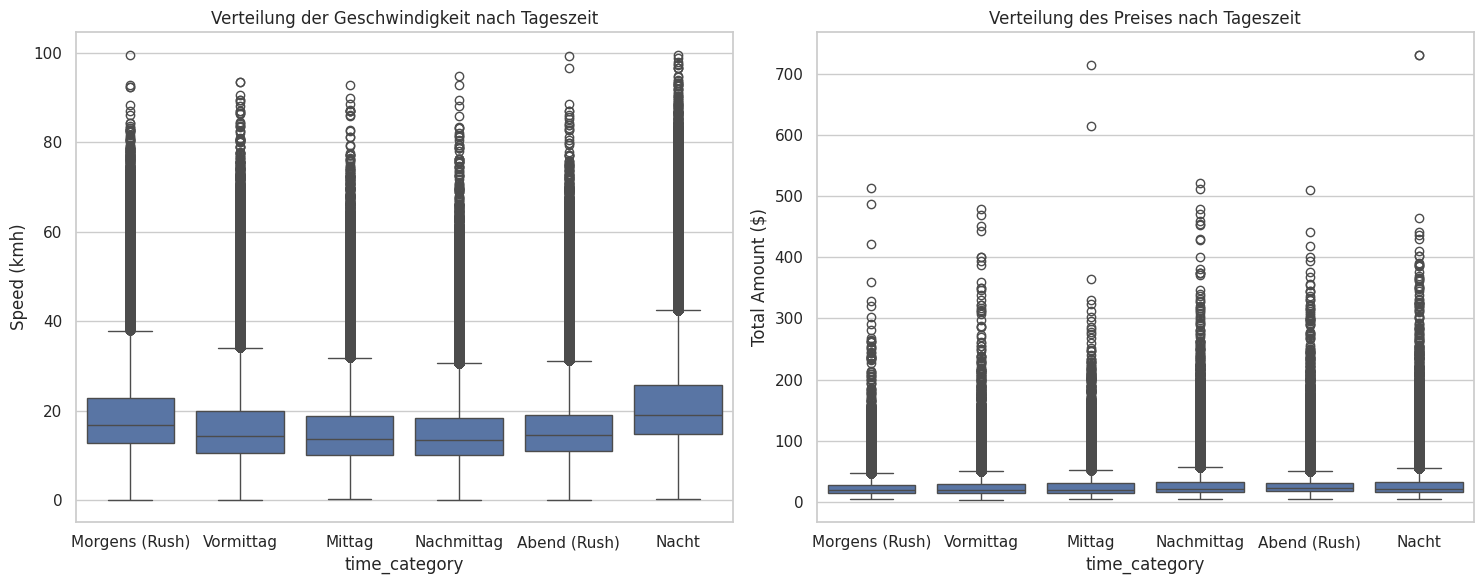

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Geschwindigkeit
sns.boxplot(x='time_category', y='average_speed', data=df, order=order, ax=axes[0])
axes[0].set_title('Verteilung der Geschwindigkeit nach Tageszeit')
axes[0].set_ylabel('Speed (kmh)')

# Plot 2: Preis
sns.boxplot(x='time_category', y='total_amount', data=df, order=order, ax=axes[1])
axes[1].set_title('Verteilung des Preises nach Tageszeit')
axes[1].set_ylabel('Total Amount ($)')

plt.tight_layout()
plt.show()

In [18]:
def test_hypothesis(variable_name, gruppen_col='time_category'):
    print(f"--- Analyse für: {variable_name} ---")
    
    # Gruppen erstellen
    groups = [df[df[gruppen_col] == g][variable_name] for g in order]
    
    # Prüfung auf Normalverteilung (Shapiro-Wilk)
    _, p_norm = st.shapiro(df[variable_name].sample(min(500, len(df)))) 
    
    print(f"Normalverteilungstest (Shapiro) p-Wert: {p_norm:.4f}")
    
    if p_norm > 0.05:
        print("-> Daten scheinen normalverteilt. Wir nutzen ANOVA.")
        stat, p_val = st.f_oneway(*groups)
        test_type = "ANOVA"
    else:
        print("-> Daten nicht normalverteilt (typisch für Taxi-Daten). Wir nutzen Kruskal-Wallis.")
        stat, p_val = st.kruskal(*groups)
        test_type = "Kruskal-Wallis"

    print(f"Ergebnis {test_type}: Statistik={stat:.2f}, p-Wert={p_val:.4e}")
    
    # Entscheidung
    alpha = 0.05
    if p_val < alpha:
        print("EVIDENZ: Es gibt signifikante Unterschiede zwischen den Tageszeiten!")
        print("Wir führen nun einen Post-hoc Test (Tukey) durch, um zu sehen, WO die Unterschiede liegen.")
        
        # Post-hoc Tukey Test
        tukey = pairwise_tukeyhsd(endog=df[variable_name], groups=df[gruppen_col], alpha=0.05)
        print(tukey.summary())
        # Visualisierung des Tukey Ergebnisses (Optional)
    else:
        print("Keine signifikanten Unterschiede gefunden. Die Hypothese kann nicht bestätigt werden.")

# Tests ausführen
test_hypothesis('average_speed')
test_hypothesis('total_amount')

--- Analyse für: average_speed ---
Normalverteilungstest (Shapiro) p-Wert: 0.0000
-> Daten nicht normalverteilt (typisch für Taxi-Daten). Wir nutzen Kruskal-Wallis.
Ergebnis Kruskal-Wallis: Statistik=86949.75, p-Wert=0.0000e+00
EVIDENZ: Es gibt signifikante Unterschiede zwischen den Tageszeiten!
Wir führen nun einen Post-hoc Test (Tukey) durch, um zu sehen, WO die Unterschiede liegen.
        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1         group2     meandiff p-adj  lower   upper  reject
-------------------------------------------------------------------
  Abend (Rush)         Mittag  -0.4219   0.0 -0.5323 -0.3115   True
  Abend (Rush) Morgens (Rush)   2.9543   0.0  2.8209  3.0877   True
  Abend (Rush)     Nachmittag  -0.9288   0.0 -1.0239 -0.8337   True
  Abend (Rush)          Nacht   5.8256   0.0  5.7404  5.9108   True
  Abend (Rush)      Vormittag   0.4496   0.0  0.3468  0.5523   True
        Mittag Morgens (Rush)   3.3762   0.0  3.2302  3.5222   True


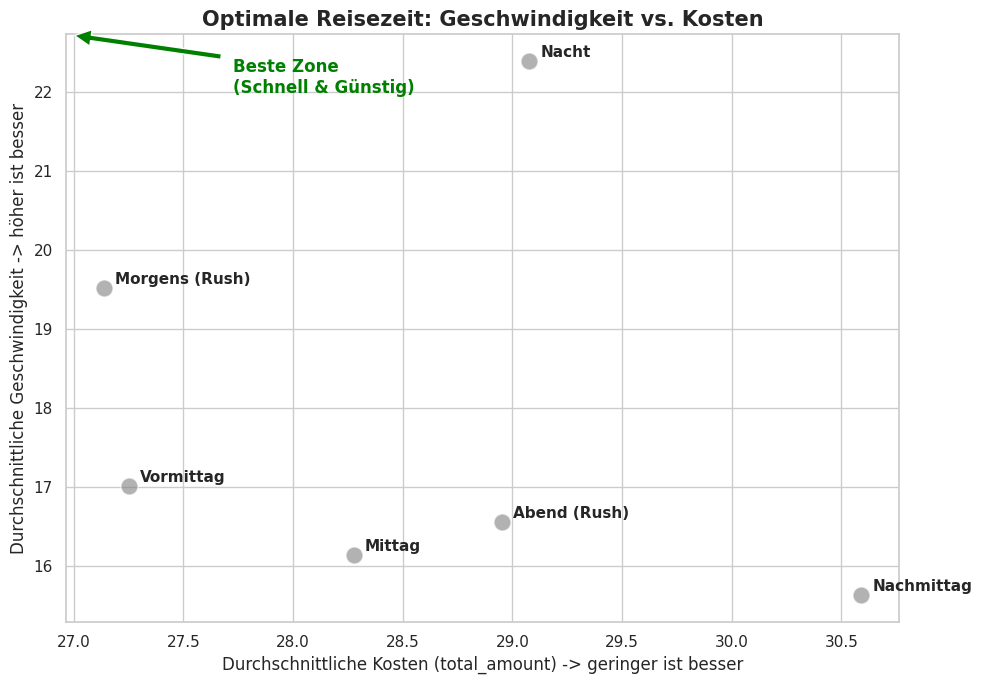

In [ ]:
summary = df.groupby('time_category')[['average_speed', 'total_amount']].mean().reset_index()

# Setup der Visualisierung
plt.figure(figsize=(10, 7))
sns.set_style("whitegrid")

# Scatter Plot erstellen
# x = Kosten (je weiter links, desto günstiger)
# y = Geschwindigkeit (je weiter oben, desto schneller)
sns.scatterplot(
    data=summary, 
    x='total_amount', 
    y='average_speed', 
    s=150,             # Größe der Punkte
    color='grey',      # Standardfarbe
    alpha=0.6
)

# Beschriftungen hinzufügen
for i in range(summary.shape[0]):
    # Verschiebung des Textes damit er nicht direkt auf dem Punkt liegt
    plt.text(
        summary.total_amount[i] + 0.05, 
        summary.average_speed[i] + 0.05, 
        summary.time_category[i], 
        fontsize=11,
        weight='bold'
    )

# Achsen und Titel formatieren
plt.title('Optimale Reisezeit: Geschwindigkeit vs. Kosten', fontsize=15, fontweight='bold')
plt.xlabel('Durchschnittliche Kosten (total_amount) -> geringer ist besser', fontsize=12)
plt.ylabel('Durchschnittliche Geschwindigkeit -> höher ist besser', fontsize=12)

x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()

# Pfeil zum optimalen Bereich
plt.annotate('Beste Zone\n(Schnell & Günstig)', 
             xy=(x_min, y_max), xycoords='data',
             xytext=(x_min + (x_max-x_min)*0.2, y_max - (y_max-y_min)*0.1), 
             arrowprops=dict(facecolor='green', shrink=0.05),
             fontsize=12, color='green', fontweight='bold')

plt.tight_layout()
plt.show()

In [21]:
check_means = df.groupby('time_category')[['average_speed', 'total_amount']].mean()

print("--- DURCHSCHNITTSWERTE ---")
print(check_means.sort_values(by='average_speed', ascending=False))

--- DURCHSCHNITTSWERTE ---
                average_speed  total_amount
time_category                              
Nacht               22.386454     29.077713
Morgens (Rush)      19.515099     27.137989
Vormittag           17.010409     27.252427
Abend (Rush)        16.560834     28.954660
Mittag              16.138920     28.276320
Nachmittag          15.632051     30.590688


# Fazit: Der Gewinner ist die "Morgens (Rush)"

Basierend auf der Analyse der Durchschnittsgeschwindigkeiten und der statistischen Signifikanztests (Kruskal-Wallis & Tukey HSD) identifizieren wir die **Morgen-Rushhour** als die leistungsstärkste Zeit des Tages.

Trotz hohem Verkehrsaufkommen bleibt die Geschwindigkeit mit **~20,8 km/h** fast auf dem Niveau des Nachtverkehrs, während sie am Nachmittag massiv einbricht.

### Warum der Morgen gewinnt: Mögliche Ursachen & Vorteile

* **Infrastruktur-Vorteil (Taxilanes):**
  Während der Individualverkehr auf den Einfallstraßen steht, können Taxis in der morgendlichen Rushhour oft **Bus- und Taxispuren** nutzen. Dies entkoppelt sie vom allgemeinen Stau und erklärt die signifikant höheren Geschwindigkeiten im Vergleich zum Nachmittag.

* **Direkte Effizienz:**
  Morgens herrscht Disziplin. Fahrgäste haben feste Termine (Arbeitsbeginn, Flughafen, Bahn).
  * **Keine Umwege:** Die Fahrten erfolgen direkt und pragmatisch.
  * **Kein "Trip-Chaining":** Anders als am Nachmittag (wo Einkäufe/Erledigungen kombiniert werden), ist der Morgenverkehr ein reiner Zielverkehr.
  * **Schnelle Abwinklung":** Weil wenig zeit geht Einsteigen und Aussteigen schneller.

* **Andere Tageszeiten könnten verzerrende Werte enthalten:**
  vielleicht warten die Taxis zu anderen Tageszeiten mehr vor Hotels oder anderen Locations um Kunden abzuholen, was sich auf die Durchschnittsgeschwindigkeit auswirkt und dann auch auf den Preis
